In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [20]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [21]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [22]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=yen_futures["Settle"].pct_change() * 100
returns.dropna(inplace=True)
returns


Date
1990-01-03    0.584197
1990-01-04    1.756933
1990-01-05   -0.827626
1990-01-08    0.129496
1990-01-09   -0.632275
                ...   
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Settle, Length: 7514, dtype: float64

### Lagged Returns 

In [37]:
# Create a lagged return using the shift function
df_returns = pd.DataFrame(returns)

df_returns.rename(columns={'Settle': 'Returns'}, inplace=True)
df_returns['Lag_1'] = df_returns['Returns'].shift()
df_returns = df_returns.dropna()
df_returns.head()


,Returns,Lag_1
Date,,
1990-01-04,1.756933,0.584197
1990-01-05,-0.827626,1.756933
1990-01-08,0.129496,-0.827626
1990-01-09,-0.632275,0.129496
1990-01-10,-0.404917,-0.632275


### Train Test Split

In [24]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = df_returns.loc[:'2017'].copy()
test = df_returns.loc['2018':].copy()

In [41]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):

import statsmodels.formula.api as smf

model = smf.ols(formula="Returns~Lag_1", data=train)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7970
Date:                Wed, 29 Sep 2021   Prob (F-statistic):              0.372
Time:                        18:17:56   Log-Likelihood:                -7561.4
No. Observations:                7062   AIC:                         1.513e+04
Df Residuals:                    7060   BIC:                         1.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0062      0.008      0.738      0.460      -0.010       0.023
Lag_1         -0.0106      0.012     -0.893      0.372      -0.034       0.013
==============================================================================
Omnibus:                     1417.830   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15241.613
Skew:                           0.648   Prob(JB):                         0.00
Kurtosis:                      10.080   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
from sklearn.linear_model import LinearRegression
lmodel = LinearRegression()
lmodel.fit(train["Lag_1"].values.reshape(-1, 1), train["Returns"].values.reshape(-1, 1))
lmodel.coef_

array([[-0.01062425]])

# Linear Regression Model

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [26]:
# Make a prediction of "y" values using just the test dataset

predicted_y_values = res.predict(test['Lag_1'])
predicted_y_values


Date
2018-01-02    0.003815
2018-01-03    0.003046
2018-01-04    0.008759
2018-01-05    0.008467
2018-01-08    0.009964
                ...   
2019-10-09    0.004388
2019-10-10    0.010566
2019-10-11    0.010129
2019-10-14    0.012199
2019-10-15    0.004596
Length: 451, dtype: float64

In [27]:
predicted_y_train = res.predict(train['Lag_1'])

In [28]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
test['predicted_returns']=predicted_y_values.copy()
train['predicted_returns']=predicted_y_train.copy()

<AxesSubplot:title={'center':'First 20 Predictions VS True Values'}, xlabel='Date'>

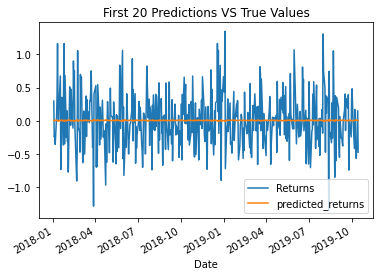

In [29]:
# Plot the first 20 predictions vs the true values
test.drop(columns=['Lag_1']).plot(title='First 20 Predictions VS True Values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [30]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
mean_squared_error(test.Returns, test.predicted_returns)
test_rmse = np.sqrt(mean_squared_error(test.Returns, test.predicted_returns))

In [31]:
test

,Returns,Lag_1,predicted_returns
Date,,,
2018-01-02,0.297285,0.224871,0.003815
2018-01-03,-0.240479,0.297285,0.003046
2018-01-04,-0.213028,-0.240479,0.008759
2018-01-05,-0.353933,-0.213028,0.008467
2018-01-08,0.062017,-0.353933,0.009964
...,...,...,...
2019-10-09,-0.410601,0.170931,0.004388
2019-10-10,-0.369458,-0.410601,0.010566
2019-10-11,-0.564304,-0.369458,0.010129


In [32]:
test_rmse

0.4136504970669482

In [33]:
train

,Returns,Lag_1,predicted_returns
Date,,,
1990-01-04,1.756933,0.584197,-0.000003
1990-01-05,-0.827626,1.756933,-0.012462
1990-01-08,0.129496,-0.827626,0.014997
1990-01-09,-0.632275,0.129496,0.004828
1990-01-10,-0.404917,-0.632275,0.012921
...,...,...,...
2017-12-22,0.118370,0.084621,0.005305
2017-12-26,0.118230,0.118370,0.004946
2017-12-27,-0.151830,0.118230,0.004948


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [34]:
mse_train = mean_squared_error(train.Returns, train.predicted_returns)

In [35]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
np.sqrt(mse_train)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)


0.7059387714146014

In [36]:
test_rmse

0.4136504970669482

# Conclusions

YOUR CONCLUSIONS HERE!

Since the RMSE is a smaller test data number, the model is underfit. We need to spend some time trying differet things like adding different variables, dates, ect. to improve the model.